#                       <font color=red>Predicting Cardiovascular Diseases </font>

In [1]:
# Target: Predicting the number of people who will have cardiovascular diseases within ten years

# Appendix
- Click on the links:
>1. <a href=#imports>Imports</a>
>2. <a href=#LoadData>Load Data</a>
>4. <a href=#DataFormating>Data Formating</a>
>5. <a href=#EDA>EDA</a>
>5. <a href=#DataSplit>Data Split</a>
>7. <a href=#0>Expr0: Baseline Model</a>
>9. <a href=#1> Expr2: with scaling</a>
>9. <a href=#2> Expr2: Decision Tree</a> 
>10.<a href=#3> Expr3: KNN</a>

# <a name='imports' >Libraries Imports</a> 

In [63]:
# import
print("importing......", flush=True)
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, fbeta_score, confusion_matrix, classification_report, make_scorer
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.classifier import StackingClassifier
from imblearn.pipeline import Pipeline

from sklearn.metrics import roc_auc_score, roc_curve,plot_roc_curve,f1_score,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

import imblearn.over_sampling

print("[Done]")

importing......
[Done]


In [70]:
# Helper Functions

def model_eval(mdl_local, X_local, y_local, bta = 1):
    y_pred = mdl_local.predict(X_local)
    print(f"F({bta}):", fbeta_score(y_local, y_pred, beta= bta))
    print("Precision :", precision_score(y_local, y_pred))
    print("Recall :", recall_score(y_local, y_pred))
    
def make_confusion_matrix(model, X_local, y_local, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_local)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_local, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['sick', 'not sick'],
           yticklabels=['sick', 'not sick']);
    plt.xlabel('prediction')
    plt.ylabel('actual')
    
def make_class_report(model, X_local, y_local, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_local)[:, 1] >= threshold)
    print(classification_report(y_local, y_predict))

# <a name='LoadData' >Load Data</a> 

In [4]:
df = pd.read_csv("Cardiovascular.csv") # Loading the dataset

In [5]:
df.head() #show the first 5 rows

,gender,age,education,current_smoker,cigs_per_day,PB_medication,hypertensive,diabetes,cholesterol_level,systolic_BP,diastolic_PB,BMI,heart_rate,glucose,ten_year_risk
0,1,39,4.0,0,0.0,0.0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [6]:
df.tail() #show the first 5 rows

,gender,age,education,current_smoker,cigs_per_day,PB_medication,hypertensive,diabetes,cholesterol_level,systolic_BP,diastolic_PB,BMI,heart_rate,glucose,ten_year_risk
4233,1,50,1.0,1,1.0,0.0,1,0,313.0,179.0,92.0,25.97,66.0,86.0,1
4234,1,51,3.0,1,43.0,0.0,0,0,207.0,126.5,80.0,19.71,65.0,68.0,0
4235,0,48,2.0,1,20.0,NaN,0,0,248.0,131.0,72.0,22.00,84.0,86.0,0
4236,0,44,1.0,1,15.0,0.0,0,0,210.0,126.5,87.0,19.16,86.0,NaN,0
4237,0,52,2.0,0,0.0,0.0,0,0,269.0,133.5,83.0,21.47,80.0,107.0,0


# <a name='DataFormating' >Data Formating</a> 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4238 non-null   int64  
 1   age                4238 non-null   int64  
 2   education          4133 non-null   float64
 3   current_smoker     4238 non-null   int64  
 4   cigs_per_day       4209 non-null   float64
 5   PB_medication      4185 non-null   float64
 6   hypertensive       4238 non-null   int64  
 7   diabetes           4238 non-null   int64  
 8   cholesterol_level  4188 non-null   float64
 9   systolic_BP        4238 non-null   float64
 10  diastolic_PB       4238 non-null   float64
 11  BMI                4219 non-null   float64
 12  heart_rate         4237 non-null   float64
 13  glucose            3850 non-null   float64
 14  ten_year_risk      4238 non-null   int64  
dtypes: float64(9), int64(6)
memory usage: 496.8 KB


In [8]:
df.shape #shows the name of columns

(4238, 15)

In [9]:
df.columns #shows the name of columns

Index(['gender', 'age', 'education', 'current_smoker', 'cigs_per_day',
       'PB_medication', 'hypertensive', 'diabetes', 'cholesterol_level',
       'systolic_BP', 'diastolic_PB', 'BMI', 'heart_rate', 'glucose',
       'ten_year_risk'],
      dtype='object')

In [10]:
df.describe() #used to view some basic statistical details like percentile, mean, std

,gender,age,education,current_smoker,cigs_per_day,PB_medication,hypertensive,diabetes,cholesterol_level,systolic_BP,diastolic_PB,BMI,heart_rate,glucose,ten_year_risk
count,4238.000000,4238.000000,4133.000000,4238.000000,4209.000000,4185.000000,4238.000000,4238.000000,4188.000000,4238.000000,4238.000000,4219.000000,4237.000000,3850.000000,4238.000000
mean,0.429212,49.584946,1.978950,0.494101,9.003089,0.029630,0.310524,0.025720,236.721585,132.352407,82.893464,25.802008,75.878924,81.966753,0.151958
std,0.495022,8.572160,1.019791,0.500024,11.920094,0.169584,0.462763,0.158316,44.590334,22.038097,11.910850,4.080111,12.026596,23.959998,0.359023
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,1.000000,0.000000,263.000000,144.000000,89.875000,28.040000,83.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


# <a name='EDA' >EDA</a> 

In [11]:
df.isna().sum()

gender                 0
age                    0
education            105
current_smoker         0
cigs_per_day          29
PB_medication         53
hypertensive           0
diabetes               0
cholesterol_level     50
systolic_BP            0
diastolic_PB           0
BMI                   19
heart_rate             1
glucose              388
ten_year_risk          0
dtype: int64

In [12]:
df.isna().sum()[(df.isna().sum() > 0)].index.to_list()

['education',
 'cigs_per_day',
 'PB_medication',
 'cholesterol_level',
 'BMI',
 'heart_rate',
 'glucose']

In [13]:
df.drop(['glucose','education'], axis="columns", inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4238 non-null   int64  
 1   age                4238 non-null   int64  
 2   current_smoker     4238 non-null   int64  
 3   cigs_per_day       4209 non-null   float64
 4   PB_medication      4185 non-null   float64
 5   hypertensive       4238 non-null   int64  
 6   diabetes           4238 non-null   int64  
 7   cholesterol_level  4188 non-null   float64
 8   systolic_BP        4238 non-null   float64
 9   diastolic_PB       4238 non-null   float64
 10  BMI                4219 non-null   float64
 11  heart_rate         4237 non-null   float64
 12  ten_year_risk      4238 non-null   int64  
dtypes: float64(7), int64(6)
memory usage: 430.5 KB


In [15]:
df.dropna(inplace=True)

In [16]:
df.isna().sum()

gender               0
age                  0
current_smoker       0
cigs_per_day         0
PB_medication        0
hypertensive         0
diabetes             0
cholesterol_level    0
systolic_BP          0
diastolic_PB         0
BMI                  0
heart_rate           0
ten_year_risk        0
dtype: int64

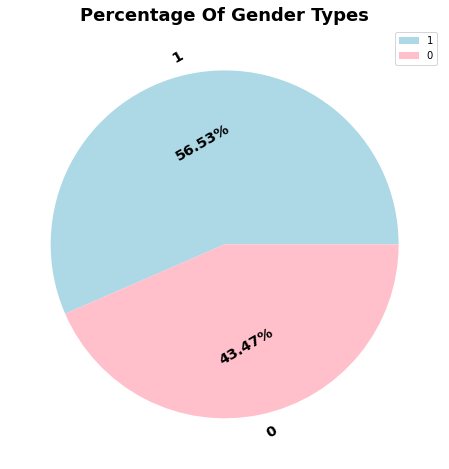

In [17]:
plt.figure(figsize = (10, 8))
plt.pie(pd.value_counts(df['gender']), 
        labels = [1,0],
        colors = ['lightblue', 'pink'],
        autopct = '%.2f%%',
        textprops = {'size' : 'x-large',
                     'fontweight' : 'bold', 
                     'rotation' : '30',
                     'color' : 'black'})

colors = ["grey", "green"]

plt.legend()
plt.title('Percentage Of Gender Types', fontsize = 18, fontweight = 'bold')
plt.show()

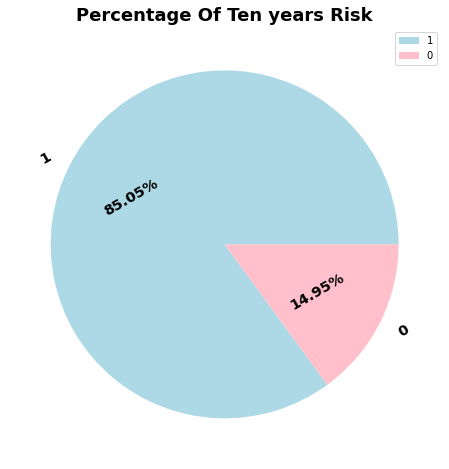

In [18]:
plt.figure(figsize = (10, 8))
plt.pie(pd.value_counts(df['ten_year_risk']),
       labels = [1,0],
       colors = ['lightblue', 'pink'],
       autopct = '%.2f%%',
       textprops = {'size' : 'x-large',
                   'fontweight' : 'bold',
                   'rotation' : '30',
                   'color' : 'black'})

plt.legend()
plt.title('Percentage Of Ten years Risk', fontsize = 18, fontweight = 'bold')
plt.show()

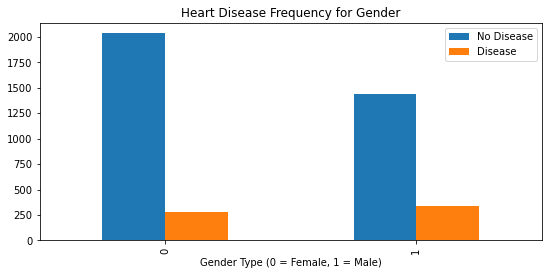

In [19]:
pd.crosstab(df.gender, df.ten_year_risk).plot(kind = 'bar', figsize = (9,4))
plt.title('Heart Disease Frequency for Gender')
plt.xlabel('Gender Type (0 = Female, 1 = Male)')
plt.legend(['No Disease', 'Disease'])

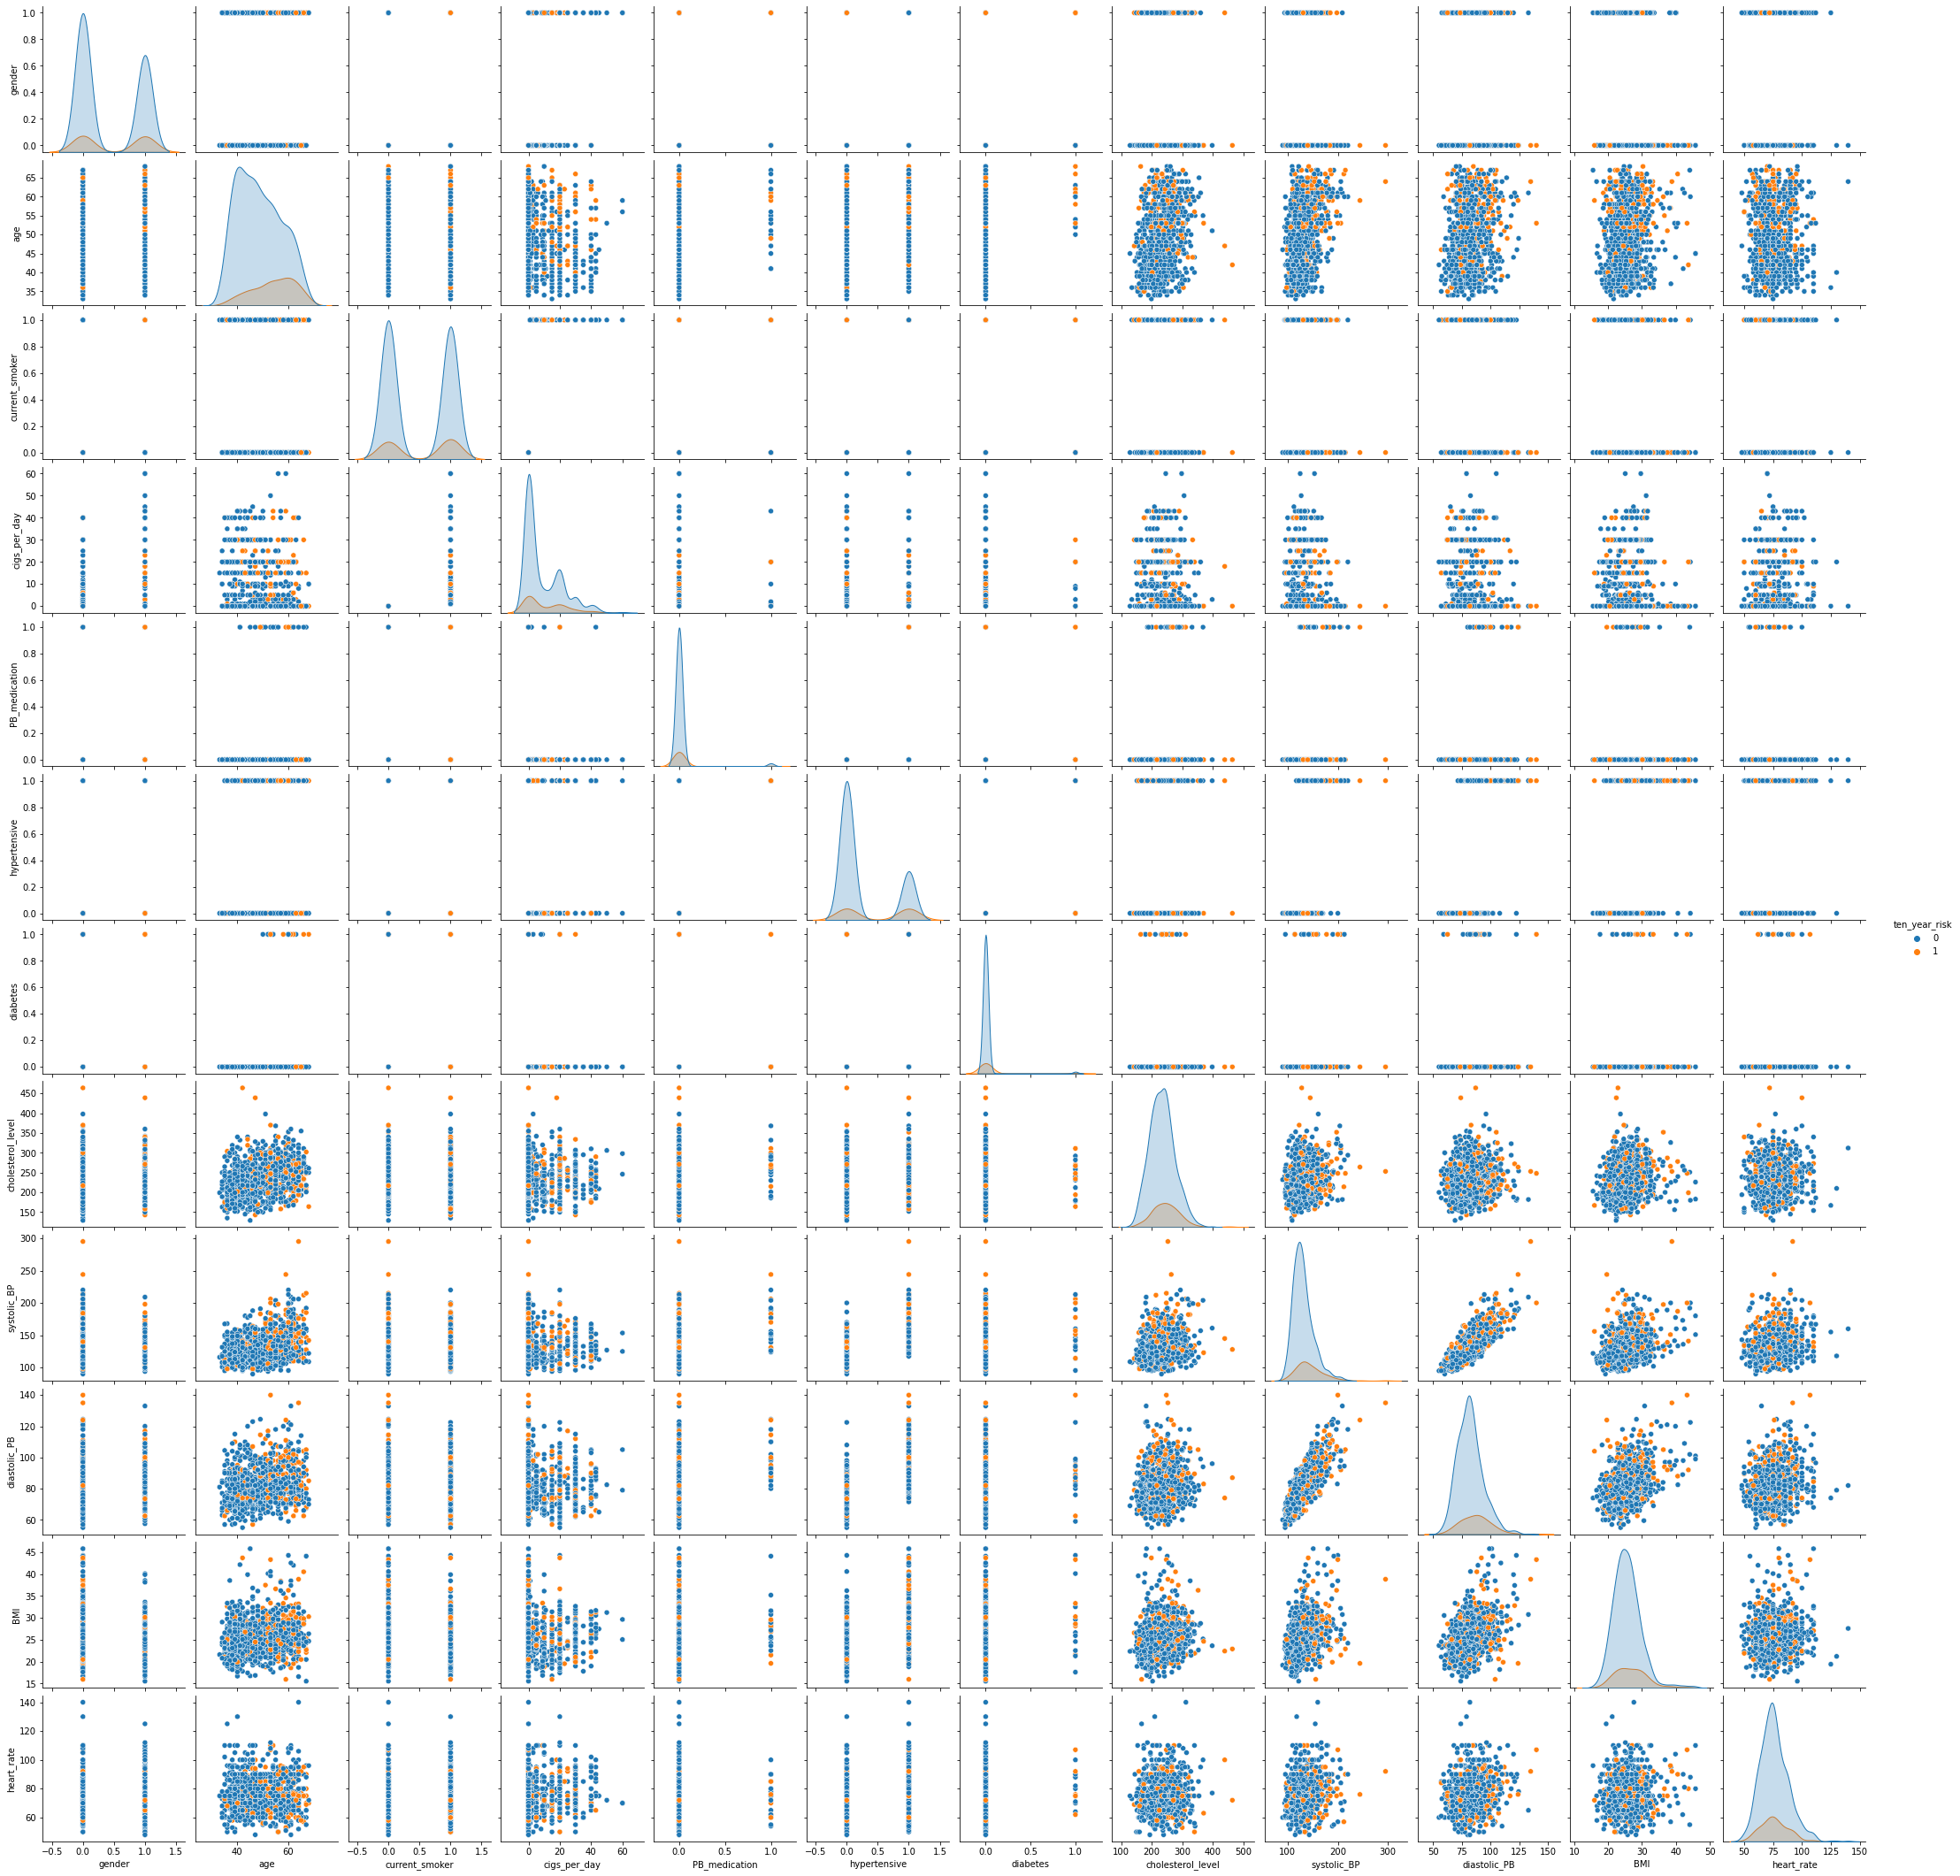

In [20]:
sns.pairplot(df[:1000],hue='ten_year_risk')

# <a name='DataSplit' >Data Split</a> 

In [21]:
X = df.drop('ten_year_risk', axis=1)

y = df['ten_year_risk']

In [22]:
X.head(3)

,gender,age,current_smoker,cigs_per_day,PB_medication,hypertensive,diabetes,cholesterol_level,systolic_BP,diastolic_PB,BMI,heart_rate
0,1,39,0,0.0,0.0,0,0,195.0,106.0,70.0,26.97,80.0
1,0,46,0,0.0,0.0,0,0,250.0,121.0,81.0,28.73,95.0
2,1,48,1,20.0,0.0,0,0,245.0,127.5,80.0,25.34,75.0


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

### Before sampling: 

<AxesSubplot:>

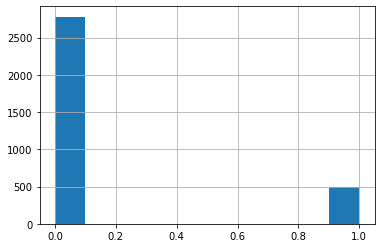

In [24]:
y_train.hist()

In [25]:
n_pos = np.sum(y_train == 1) 
n_neg = np.sum(y_train == 0)
ratio = {1 : n_pos * 5, 0 : n_neg}  

ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy= ratio, random_state=42) 
    
X_train_rs, y_tr_rs = ROS.fit_resample(X_train, y_train)

### Oversampling

<AxesSubplot:>

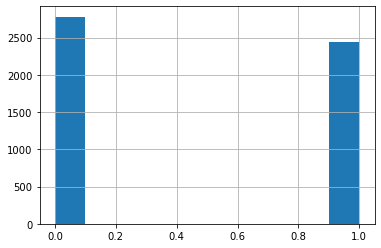

In [26]:
y_tr_rs.hist()

# <a name='0' >Expr1: Baseline Model</a> 

In [27]:
baseline = LogisticRegression(max_iter=500)
baseline.fit(X_train_rs, y_tr_rs)
print(f'Train score: {baseline.score(X_train_rs, y_tr_rs)}')
print(f'Test score: {baseline.score(X_test, y_test)}')

model_eval(baseline, X_test, y_test)

Train score: 0.6777650210486031
Test score: 0.7200488997555012
F(1): 0.4082687338501292
Precision : 0.2981132075471698
Recall : 0.6475409836065574


C:\Users\alaa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# <a name='0' >Expr1: Scaling</a> 

In [28]:
ss = StandardScaler()

X_train_std = ss.fit_transform(X_train_rs)
X_test_std = ss.transform(X_test)

# Modeling
baseline = LogisticRegression()
baseline.fit(X_train_std, y_tr_rs)


print(f'Train score: {baseline.score(X_train_std, y_tr_rs)}')
print(f'Test score: {baseline.score(X_test_std , y_test)}')

model_eval(baseline, X_test_std , y_test)

Train score: 0.6789131266743207
Test score: 0.71760391198044
F(1): 0.4061696658097687
Precision : 0.2958801498127341
Recall : 0.6475409836065574


In [32]:
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy= ratio, random_state=42)

pipeline = Pipeline([('ROS', ROS), ('lg', LogisticRegression(max_iter=500))])

params = {"lg__penalty":['l2','l1'],"lg__C" : np.arange(0.1,50,0.2),"lg__fit_intercept":[True, False]}

gcv_lg= RandomizedSearchCV(pipeline, params, cv = 10, n_jobs=-1, verbose=10, scoring = 'f1') 
gcv_lg.fit(X_train, y_train) 

Fitting 10 folds for each of 10 candidates, totalling 100 fits


C:\Users\alaa\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.35884445 0.38619446
        nan 0.38548287 0.35982819 0.35884445]
  warnings.warn(
C:\Users\alaa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('ROS',
                                              RandomOverSampler(random_state=42,
                                                                sampling_strategy={0: 2781,
                                                                                   1: 2445})),
                                             ('lg',
                                              LogisticRegression(max_iter=500))]),
                   n_jobs=-1,
                   param_distributions={'lg__C': array([ 0.1,  0.3,  0.5,  0.7,  0.9,  1.1,  1.3,  1.5,  1.7,  1.9,  2.1,
        2.3,  2.5,  2.7,  2.9,  3.1,  3.3,  3.5,  3.7,  3.9,  4.1,  4.3,
        4.5,  4.7,  4.9,  5.1,  5.3,  5.5,  5.7,  5.9,  6.1,  6.3,  6.5,
        6....
       37.5, 37.7, 37.9, 38.1, 38.3, 38.5, 38.7, 38.9, 39.1, 39.3, 39.5,
       39.7, 39.9, 40.1, 40.3, 40.5, 40.7, 40.9, 41.1, 41.3, 41.5, 41.7,
       41.9, 42.1, 42.3, 42.5, 42.7, 42.9, 43.1, 43.3, 43.5,

In [33]:
# this best score is f1
print(gcv_lg.best_score_)
print(gcv_lg.best_params_)

0.3861944606267224
{'lg__penalty': 'l2', 'lg__fit_intercept': True, 'lg__C': 6.1000000000000005}


In [34]:
tuned_lg = gcv_lg.best_estimator_

print(f'Train score: {tuned_lg.score(X_train, y_train)}')
print(f'Test score: {tuned_lg.score(X_test, y_test)}')

model_eval(tuned_lg, X_test, y_test)

Train score: 0.7051987767584098
Test score: 0.7163814180929096
F(1): 0.4020618556701031
Precision : 0.2932330827067669
Recall : 0.639344262295082


# <a name='0' >Expr2: Decision Tree</a> 

In [35]:
decisiontree = DecisionTreeClassifier()

decisiontree.fit(X_train_rs, y_tr_rs)
print(f'Train score: {decisiontree.score(X_train_rs, y_tr_rs)}')
print(f'Test score: {decisiontree.score(X_test,y_test)}')
model_eval(decisiontree, X_test, y_test)

Train score: 1.0
Test score: 0.7897310513447433
F(1): 0.2773109243697479
Precision : 0.28448275862068967
Recall : 0.27049180327868855


In [171]:
###pipeline with oversampler and then gridsearch  

In [36]:
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline

ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy= ratio, random_state=42)

pipeline = Pipeline([('ROS', ROS), ('dt', DecisionTreeClassifier())])

params = {'dt__max_depth' : [3, 5, 7, 8, 11, 12],'dt__min_samples_split' : [2, 3, 5, 9], 'dt__criterion' : ["gini", "entropy"]}

gcv_dt= RandomizedSearchCV(pipeline, params, cv = 10, n_jobs=-1, verbose=10, scoring = 'f1')
gcv_dt.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('ROS',
                                              RandomOverSampler(random_state=42,
                                                                sampling_strategy={0: 2781,
                                                                                   1: 2445})),
                                             ('dt', DecisionTreeClassifier())]),
                   n_jobs=-1,
                   param_distributions={'dt__criterion': ['gini', 'entropy'],
                                        'dt__max_depth': [3, 5, 7, 8, 11, 12],
                                        'dt__min_samples_split': [2, 3, 5, 9]},
                   scoring='f1', verbose=10)

In [37]:
# this best score is f1
print(gcv_dt.best_score_)
print(gcv_dt.best_params_)

0.32624783698039195
{'dt__min_samples_split': 2, 'dt__max_depth': 7, 'dt__criterion': 'entropy'}


In [38]:
tuned_dt = gcv_dt.best_estimator_

print(f'Train score: {tuned_dt.score(X_train, y_train)}')
print(f'Test score: {tuned_dt.score(X_test, y_test)}')

model_eval(tuned_dt, X_test, y_test)

Train score: 0.7412844036697248
Test score: 0.6748166259168704
F(1): 0.3636363636363636
Precision : 0.25675675675675674
Recall : 0.6229508196721312


# <a name='0' >Expr3: Random Forest</a> 

In [39]:
randomforest = RandomForestClassifier()

randomforest.fit(X_train_rs, y_tr_rs)
print(f'Train score: {randomforest.score(X_train_rs, y_tr_rs)}')
print(f'Test score: {randomforest.score(X_test, y_test)}')

model_eval(randomforest, X_test, y_test)

Train score: 1.0
Test score: 0.8374083129584352
F(1): 0.19393939393939394
Precision : 0.37209302325581395
Recall : 0.13114754098360656


In [41]:
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy= ratio, random_state=42)
pipeline = Pipeline([('ROS', ROS), ('RF', RandomForestClassifier())])

params = {'RF__max_depth' : [3, 5, 7, 8, 11, 12],'RF__min_samples_split' : [2, 3, 5, 9], 'RF__criterion' : ["gini", "entropy"]}

gcv_rf = RandomizedSearchCV(pipeline,  params, n_jobs=-1, cv=10, verbose=10, scoring = 'f1')
gcv_rf.fit(X_train, y_train)



Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('ROS',
                                              RandomOverSampler(random_state=42,
                                                                sampling_strategy={0: 2781,
                                                                                   1: 2445})),
                                             ('RF', RandomForestClassifier())]),
                   n_jobs=-1,
                   param_distributions={'RF__criterion': ['gini', 'entropy'],
                                        'RF__max_depth': [3, 5, 7, 8, 11, 12],
                                        'RF__min_samples_split': [2, 3, 5, 9]},
                   scoring='f1', verbose=10)

In [42]:
print(gcv_rf.best_score_)
print(gcv_rf.best_params_)

0.3733483407835973
{'RF__min_samples_split': 9, 'RF__max_depth': 3, 'RF__criterion': 'entropy'}


In [43]:
tuned_rf = gcv_rf.best_estimator_

print(f'Train score: {tuned_rf.score(X_train, y_train)}')
print(f'Test score: {tuned_rf.score(X_test, y_test)}')

model_eval(tuned_rf, X_test, y_test)

Train score: 0.7299694189602447
Test score: 0.71760391198044
F(1): 0.3905013192612137
Precision : 0.28793774319066145
Recall : 0.6065573770491803


# <a name='0' >Expr4:  KNN</a> 

In [44]:
knn = KNeighborsClassifier()
knn.fit(X_train_rs, y_tr_rs)
print(f'Train score: {knn.score(X_train_rs, y_tr_rs)}')
print(f'Test score: {knn.score(X_test, y_test)}')
model_eval(knn, X_test, y_test)

Train score: 0.8733256792958285
Test score: 0.6687041564792175
F(1): 0.2887139107611549
Precision : 0.21235521235521235
Recall : 0.45081967213114754


In [46]:
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy= ratio, random_state=42)

pipeline = Pipeline([('ROS', ROS), ('KN', KNeighborsClassifier())])

k_range = list(range(1, 100))
params = {'KN__n_neighbors': k_range}

gs_knn = RandomizedSearchCV(pipeline,   params, n_jobs=-1, cv=10, verbose=10, scoring = 'f1')
gs_knn.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('ROS',
                                              RandomOverSampler(random_state=42,
                                                                sampling_strategy={0: 2781,
                                                                                   1: 2445})),
                                             ('KN', KNeighborsClassifier())]),
                   n_jobs=-1,
                   param_distributions={'KN__n_neighbors': [1, 2, 3, 4, 5, 6, 7,
                                                            8, 9, 10, 11, 12,
                                                            13, 14, 15, 16, 17,
                                                            18, 19, 20, 21, 22,
                                                            23, 24, 25, 26, 27,
                                                            28, 29, 30, ...]},
                   scoring='f1', verbose=10)

In [47]:
print(gs_knn.best_score_)
print(gs_knn.best_params_)

0.33707960591683783
{'KN__n_neighbors': 93}


In [48]:
tuned_knn = gs_knn.best_estimator_

print(f'Train score: {tuned_knn.score(X_train, y_train)}')
print(f'Test score: {tuned_knn.score(X_test, y_test)}')


model_eval(tuned_knn, X_test, y_test)

Train score: 0.7070336391437309
Test score: 0.7029339853300733
F(1): 0.34501347708894875
Precision : 0.2570281124497992
Recall : 0.5245901639344263


In [49]:
model_names=["baseline",'tuned_lg','tuned_dt',"tuned_rf",'tuned_knn']

In [50]:
model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

## Best model 

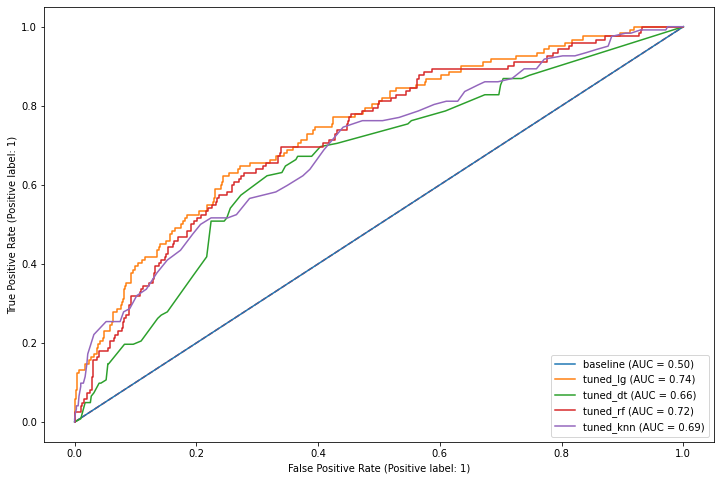

In [56]:
plt.figure(figsize=(12,8))
plt.plot([0, 1], [0, 1], 'r--')
model_list = list(zip(model_names, model_vars))
ax = plt.gca()
for model_name in model_names:
    curr_model = eval(model_name)
    plot_roc_curve(curr_model, X_test, y_test, ax=ax, name=model_name )

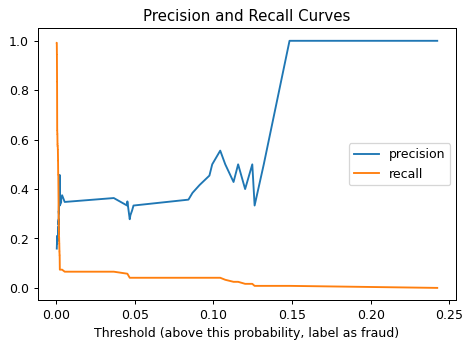

In [69]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, tuned_lg.predict_proba(X_test_std)[:,1] )

plt.figure(dpi=90)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='center right')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

C:\Users\alaa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alaa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alaa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alaa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is i

random forest Model best F1 score 0.412 at prob decision threshold >= 0.515


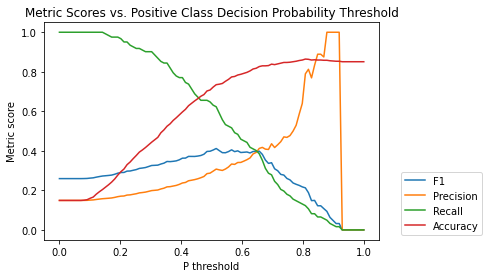

In [64]:
thresh_ps =np.linspace(0, 1, num=100)
model_test_probs = tuned_lg.predict_proba(X_test)[:,1]
f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_test_labels = model_test_probs >= p
    f1_scores.append(f1_score(y_test, model_test_labels))
    prec_scores.append(precision_score(y_test, model_test_labels))
    rec_scores.append(recall_score(y_test, model_test_labels))
    acc_scores.append(accuracy_score(y_test, model_test_labels))
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)
plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1','Precision','Recall','Accuracy'], bbox_to_anchor=(1.05, 0), loc='lower left')
plt.xlabel('P threshold')
plt.ylabel('Metric score')
best_f1_score = np.max(f1_scores)
best_thresh_p = thresh_ps[np.argmax(f1_scores)]
print('random forest Model best F1 score %.3f at prob decision threshold >= %.3f'
      % (best_f1_score, best_thresh_p))


In [180]:
from ipywidgets import interactive, FloatSlider

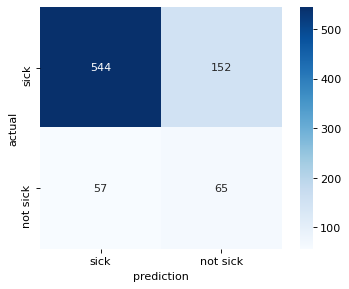

In [71]:
 make_confusion_matrix(tuned_rf, X_test, y_test, threshold=0.515)
